# The purpose of this notebook is to build a machine learning model to predict whether or not a compression took place

In [1]:
import pandas as pd
import numpy as np

# Utilities file
import utility as util

from collections import OrderedDict
from itertools import product

# modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    auc,
    brier_score_loss,
)
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import data
df = pd.read_csv('data/labeled_comp.csv')

In [3]:
df.head()

,Time (s),Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2),Absolute acceleration (m/s^2),object,prev_time,time_delta,rolling_stdev,is_compression
0,0.016569,-0.079748,-0.011341,1.189440,1.192164,mattress,NaN,NaN,NaN,0
1,0.026562,-0.009065,-0.054324,1.198593,1.199857,mattress,0.016569,0.009993,NaN,0
2,0.036555,0.080083,-0.027440,0.352316,0.362343,mattress,0.026562,0.009993,NaN,0
3,0.046548,0.092367,-0.035558,-0.328451,0.343039,mattress,0.036555,0.009993,NaN,0
4,0.056541,0.074421,-0.023063,-0.515041,0.520901,mattress,0.046548,0.009993,NaN,0


In [7]:
# Label balance
df['is_compression'].value_counts(normalize=True)

0    0.989319
1    0.010681
Name: is_compression, dtype: float64

## When modeling, it's important to think about how this model will be used in a production setting. Model results will need to be quick. Therefore, it would be best for us to use an existing sensor reading rather than building a new one.

In [5]:
# Select features and target
X = df[['Acceleration x (m/s^2)', 'Acceleration y (m/s^2)', 'Acceleration z (m/s^2)', 'Absolute acceleration (m/s^2)']]
y = df['is_compression']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestClassifier(n_estimators=200, 
                               random_state = 11,
                               n_jobs=-1, 
                               class_weight = 'balanced',
                               verbose=True, 
                               max_depth=10,
                               min_samples_leaf=1)


# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.1s finished


### Model Metrics

In [6]:
# Make sure the model isn't overfitting the training data
rf_train_prob = model.predict_proba(X_train)[:, 1]
rf_test_prob = model.predict_proba(X_test)[:, 1]

### Get Model Stats:
# Get test metrics
rf_test_pred = rf_test_prob > 0.5
util.model_stats(y_train, rf_train_prob, y_test, rf_test_prob, rf_test_pred)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.1s finished


,accuracy,precision,recall,f1,roc_auc,tpr,tnr,1-fpr,1-fnr,brier_gain,1-ks,lift_statistic
0,0.993114,0.638587,0.943775,0.76175,0.998479,0.943775,0.993696,0.993696,0.943775,0.994881,0.866037,0.910622


### Grid search

In [8]:
grid_search = True

if grid_search:
    # specify parameters and distributions to sample from
    param_list = {"max_depth": [3,5,7],
                  "learning_rate": [0.1],
                  "scale_pos_weight": [3, 5]
                 }

    print("defining the model")
    # run randomized search
    model = XGBClassifier(n_estimators = 375,
                          n_jobs = -1,
                          silent = False)

    # running the grid search
    xgb = GridSearchCV(model, param_list, scoring = "f1",verbose=2)
    %time xgb.fit(X_train, y_train)

else:
    xgb = XGBClassifier(n_estimators = 375,
                          n_jobs = -1,
                          silent = True,
                          max_depth = 3,
                          learning_rate = 0.1,
                          scale_pos_weight = 3
                         )

    print("Fitting the model")
    xgb.fit(X_train, y_train)

defining the model
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .learning_rate=0.1, max_depth=3, scale_pos_weight=3; total time=   3.9s
[CV] END .learning_rate=0.1, max_depth=3, scale_pos_weight=3; total time=   3.6s
[CV] END .learning_rate=0.1, max_depth=3, scale_pos_weight=3; total time=   3.5s
[CV] END .learning_rate=0.1, max_depth=3, scale_pos_weight=3; total time=   3.8s
[CV] END .learning_rate=0.1, max_depth=3, scale_pos_weight=3; total time=   3.7s
[CV] END .learning_rate=0.1, max_depth=3, scale_pos_weight=5; total time=   3.6s
[CV] END .learning_rate=0.1, max_depth=3, scale_pos_weight=5; total time=   3.7s
[CV] END .learning_rate=0.1, max_depth=3, scale_pos_weight=5; total time=   3.6s
[CV] END .learning_rate=0.1, max_depth=3, scale_pos_weight=5; total time=   3.7s
[CV] END .learning_rate=0.1, max_depth=3, scale_pos_weight=5; total time=   3.8s
[CV] END .learning_rate=0.1, max_depth=5, scale_pos_weight=3; total time=   5.6s
[CV] END .learning_rate=0.1, m

In [9]:
xgb.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'scale_pos_weight': 3}

In [10]:
# Make sure the model isn't overfitting the training data
xgb_train_prob = xgb.predict_proba(X_train)[:, 1]
xgb_test_prob = xgb.predict_proba(X_test)[:, 1]

### Get Model Stats:
# Get test metrics
xgb_test_pred = xgb_test_prob > 0.5
util.model_stats(y_train, xgb_train_prob, y_test, xgb_test_prob, xgb_test_pred)

,accuracy,precision,recall,f1,roc_auc,tpr,tnr,1-fpr,1-fnr,brier_gain,1-ks,lift_statistic
0,0.996768,0.833333,0.903614,0.867052,0.999144,0.903614,0.997867,0.997867,0.903614,0.997496,0.902695,0.910622


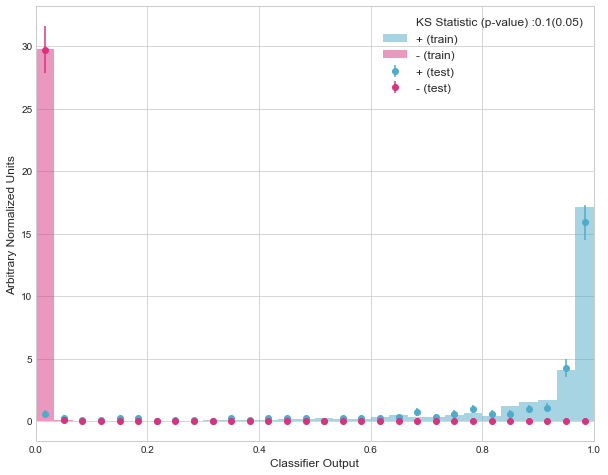

In [11]:
util.make_ks_plot(y_train,xgb_train_prob,y_test,xgb_test_prob,label='is_compression')